# Performance comparison of 2D finite difference wave propagation implementations
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

I [previously](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb) investigated the performance of 1D finite difference wave propagation implemented using Python, Numba, C and Fortran (and, [in another notebook](https://github.com/ar4/wave_1d_fd_tf/blob/master/notebooks/wave_1d_fd_tf.ipynb), TensorFlow). This notebook is the same idea, but this time we are expanding into the second dimension.

Once again, I will be using a 16th order in space, 2nd order in time finite difference scalar wave equation propagator, with hard boundaries to keep the code simple. The code gets called from Python, to simulate the situation where most of a RTM/FWI code is written in Python, and the computationally expensive wave propagation component is written in something that gives better performance. One change from the 1D notebook is that I won't be considering Python, Numba, or TensorFlow for the wave propagation implementation. They were pretty slow in 1D, so I don't want to try them in 2D.

The different implementations vary only in the way the code is written, attempting to enhance vectorization or reduce cache misses. I am thus not considering the possibility that you might get better performance by changing the propagator to something other than standard finite difference.

The performance of finite difference codes is typically limited by memory bandwidth. A lot of values are required from memory for each calculation, and the calculations are very simple. That means that the CPU cores spend much of their time idle, waiting for data to arrive. It is therefore likely that the most promising performance optimizations are those that reduce unnecessary memory accesses.

I use compiler options that may affect numerical accuracy, such as `-Ofast`, but in all cases, the wavefield after propagating for 0.2 s (333 time steps) in my test model is within `5e-4` of the wavefield when propagating with the most obvious implementation (VC1 below) compiled using `-O2`. In fact, the difference in the output is larger between the most conservative C and Fortran versions than between all of the C versions.

With the exception of one (VC6 256), all of the implementations are strictly standards compliant and so it should be possible to compile them with any compiler. Another one, VC15, includes a GCC-specific `#pragma`, but that shouldn't stop it compiling with other compilers. It may be possible to get better performance using compiler or operating system-specific intrinsics, but that is not my goal in this notebook.


## Implementations

I tried quite a few different implementations and won't go through all of them.

### [VC1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc1.c)
This is the most obvious way of implementing the method using C. It primarily consists of four loops: the outer loop is over time steps, inside that is a loop over `y`, inside that a loop over `x`, and inside that there is, among other things, a loop over the finite difference coefficients that are used to calculate the spatial derivative of the wavefield. The code is clear and concise (only 64 lines).

### [VC2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc2.c)
The only way in which VC2 differs from VC1 is the inner loop. Instead of having a loop over the finite difference coefficients, I have manually unrolled the loop. The advantage of this is that it makes it very clear to the compiler that all of the memory accesses needed for the computation can be done simultaneously and none of the intermediate results need to be written to memory. This makes the code longer (96 lines), uglier, and less flexible (changing the order of the finite difference stencil requires more than just updating the end condition of a loop now). Surely this is terrible coding practice? Perhaps, but in High Performance Computing, unlike in most other fields, processing time is more expensive than programmer time. Spending a day to get a 5% performance improvement is often worthwhile for a code that is going to run almost continuously on thousands of cores. The other argument against this type of optimization is that it should surely have been done by the compiler. I would have thought that likely too - it seems obvious that it is safe to unroll this loop, but we shall have to wait for the results to see if that is the case.

### [VC3](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc3.c), [VC4](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc4.c)
These are the same as VC1 and VC2, respectively, with the modification of moving the computation inside the time step loop into a separate function. GCC reported that it could not vectorize the computation because it wasn't able to determine that there were no dependencies. I guessed that this was due to the pointer swapping that happens at the end of each time step (the memory that was the wavefield at the current time step is now the wavefield at the previous time step). GCC reports that it does vectorize these versions. It is possible to explicitly tell the compiler that it is safe to vectorize with `#pragma GCC ivdep`. I verified with [VC15](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc15.c) that it does then vectorize without creating a new function, but I prefer to avoid compiler-specific code when possible.

### [VC6](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc6.c)
This is VC4 with OpenMP parallelization of the loop over `y`, ensuring that all of the cores, and, more importantly, all of the cache storage and memory bandwidth, is used.

### [VC8](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc8.c)
VC6 is extended to use blocking over `x` and `y`. Instead of completing all of one row before starting on the next, with blocking the calculation is performed on small 2D blocks. The calculation for cell `[x, y]` requires data from cells between `[x - 8, y]` and `[x + 8, y]`, but also from `[x, y - 8]` to `[x, y + 8]`. These values will be stored in cache after the computation. If the computation continues on along the row, the columns (different `y` values) of data will not be used again until the computation reaches the same `x` value on the next row. For long rows, the columns will probably have been erased from the cache memory by then, and so that data will need to be loaded from main memory again. By working in 2D blocks, a higher percentage of the data used in the computations will already be in the cache when it is needed, reducing memory bandwidth consumption and average latency.

### [VC11](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vc11.c)
This is equivalent to VC4 from my 1D notebook. It is like this notebook's VC6, but instead of OpenMP being applied to the `y` loop, an OpenMP parallel region is created around the time step loop. This makes the code more complicated, but has the advantages of avoiding the need to create and destroy threads every time step and allowing sources to be added by the threads that "own" the part of the domain where they are located (with potential memory access benefits).

### [VF1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf1.f90), [VF2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf2.f90)
These are the Fortran equivalents of VC1 and VC2.

### [VF3](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf3.f90), [VF5](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf5.f90)
In VF3, Fortan 95's `forall` is used for the loops over `x` and `y`, while VF5 does the same but with Fortran 2008's `do concurrent`. To indicate to the compiler that the operations inside these loops do not have side-effects, the operations they contain are moved into separate `pure` functions.

### [VF4](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf4.f90), [VF6](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vf6.f90)
These are the same as VF3 and VF5, respectively, but without moving the operations into separate functions.

### [VCython1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vcython1.pyx), [VCython2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vcython2.pyx)
These are translations of VC1 and VC6 into Cython.

### [VPytorch1](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vpytorch1.py)
This PyTorch implementation uses a single 2D convolution, with PyTorch's built-in convolution function, to calculate the Laplacian.

### [VPytorch2](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vpytorch2.py)
Like VPytorch1, but using a simple hand-written convolution instead of the built-in function.

### [VPytorch3](https://github.com/ar4/wave_2d_fd_perf/blob/master/wave_2d_fd_perf/vpytorch3.py)
This version uses the built-in convolution function, like VPytorch1, but unlike that version it splits the convolution into two parts (one in the x dimension and one in the y dimension). This exploits the sparseness of the 2D Laplacian kernel to reduce the number of unnecessary multiplications by zero, but also means that two passes are necessary, wasting memory bandwidth.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wave_2d_fd_perf import propagators, test_wave_2d_fd_perf, run_timing, run_timing_blocksize
from wave_2d_fd_perf.propagators import (VC1_O2_gcc, VC1_O3_gcc, VC1_Ofast_gcc, VC2_O2_gcc, VC2_O3_gcc, VC2_Ofast_gcc, VC3_Ofast_gcc, VC3_Ofast_unroll_gcc, VC4_Ofast_gcc, VC4_Ofast_extra1_gcc, VC4_Ofast_extra2_gcc, VC4_Ofast_extra3_gcc, VC5_Ofast_gcc, VC6_Ofast_gcc, VC6_256_Ofast_gcc, VC7_Ofast_gcc, VC8_Ofast_gcc, VC9_Ofast_gcc, VC10_Ofast_gcc, VC11_Ofast_gcc, VC12_Ofast_gcc, VC13_Ofast_gcc, VC14_Ofast_gcc, VC15_Ofast_gcc, VF1_O2_gcc, VF1_O3_gcc, VF1_Ofast_gcc, VF2_Ofast_gcc, VF3_Ofast_gcc, VF4_Ofast_gcc, VF5_Ofast_gcc, VF6_Ofast_gcc, VF6_Ofast_autopar_gcc)
from wave_2d_fd_perf.propagators import (VC8a_Ofast_gcc, VC9a_Ofast_gcc, VC10a_Ofast_gcc)

## Results

I generated the results below using the following system (which is a cloud instance).

In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz
Stepping:              2
CPU MHz:               2397.164
BogoMIPS:              4794.32
Hypervisor vendor:     Microsoft
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K
NUMA node0 CPU(s):     0-7
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx lm constant_tsc rep_good nopl eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm fsgsbase bmi1 avx2 sm

In [3]:
!gcc --version

gcc (Ubuntu 5.4.0-6ubuntu1~16.04.4) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



### Block size

VC8 uses cache blocking, but for this to be effective we need to tune the block size. With multiple levels of cache, some shared by multiple threads running in parallel, it is not obvious what block size will work best.

We need to tune both the block size in the `x` (fast) dimension, and also in the `y` (slow) dimension. To do this I will simply run the propagator for different block size combinations and measure the run time. To avoid tuning for a specific model size (if a specific block size divides evenly into the model size, it will probably run faster), I run each block size combination with several different model sizes and sum the run times.

In [4]:
blocksizes_y = [1, 8, 16, 32, 64]
blocksizes_x = [8, 16, 32, 64, 128, 256, 512]
t8 = run_timing_blocksize.run_timing_model_size(num_repeat=5, num_steps=10, model_sizes=range(2000, 2500, 5), versions=[{'class': VC8a_Ofast_gcc, 'name': '8'}], blocksizes_y=blocksizes_y, blocksizes_x=blocksizes_x, align=256)

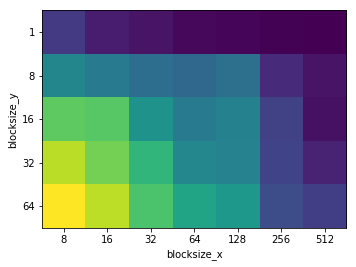

In [13]:
ax = plt.subplot(111)
ax.imshow(t8.groupby(['blocksize_y', 'blocksize_x']).mean()['time'].values.reshape(len(blocksizes_y), len(blocksizes_x)))
plt.xlabel('blocksize_x')
plt.ylabel('blocksize_y')
ax.set_xticks(range(0,len(blocksizes_x)))
ax.set_yticks(range(0,len(blocksizes_y)))
ax.set_yticklabels(blocksizes_y);
ax.set_xticklabels(blocksizes_x);

It seems that blocking is in fact not helpful in this case: the best performance (blue represents the smallest run time) is obtained when using a blocksize of 1 in the `y` direction, which is the same as not having blocks at all.

There are a few possible explanations for this. One is that it is a result of running on a virtual CPU cloud instance. Another is that the rows might not have been long enough for the data from column `x` to have been evicted from the cache by the time the non-blocked computation gets back around to column `x` again on the next row. If the latter is true, then the benefit of cache blocking would be more apparent for 3D propagation, as then it would be far less likely that the cache could store a whole row.

For comparison, I also ran this test on another system. This one was a real ("bare metal") CPU, and a few years older than the cloud one (an Intel Core i7 930). This time the results (below) were closer to my expectations. Blocks with 8 cells in `y` and 16 cells in `x` give good performance now. Even here, big block sizes in the `x` direction continue to perform well, so perhaps blocking is simply not really necessary for 2D propagation.

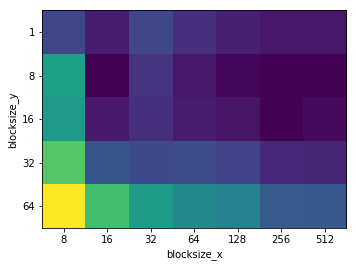

I wanted to do one more test to see if I could determine whether the cloud CPU really was storing the whole row in cache. It seems possible that with 2000 cell rows L2 cache might be big enough: 2000 x 16 x 4 bytes is 125 KB, which is smaller than the L2 cache size. I timed the propagation on a larger model with over 10000 cells per row, and tested `x` blocksizes of 1024 and 2048. You can see from the table below that this time there was a slight performance improvement when using a blocksize of 8 in the `y` direction. This suggests that the hypothesis might be true.

In [61]:
blocksizes_y = [1, 8]
blocksizes_x = [1024, 2048]
t82 = run_timing_blocksize.run_timing_model_size(num_repeat=1, num_steps=10, model_sizes=range(10000, 10500, 50), versions=[{'class': VC8a_Ofast_gcc, 'name': '8'}], blocksizes_y=blocksizes_y, blocksizes_x=blocksizes_x, align=256)

t82.groupby(['blocksize_y', 'blocksize_x']).mean()

num_steps  model_size      time
blocksize_y blocksize_x                                 
1.0         1024.0            10.0     10225.0  2.708906
            2048.0            10.0     10225.0  2.716276
8.0         1024.0            10.0     10225.0  2.693187
            2048.0            10.0     10225.0  2.647970

### All implementations on a fixed model size

I will now time all of the different implementations on a 2000 x 2000 cell model.

In [14]:
t = run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=[2000])

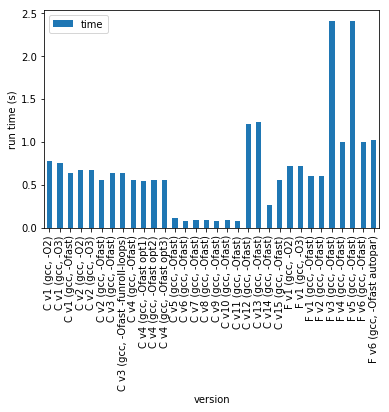

In [15]:
t.plot.bar(x='version', y='time')
plt.ylabel('run time (s)')

There are lots of interesting things to observe here.

The first is that, for this code, there is no significant change in run time between versions of the code compiled with `-O2` and `-O3`, but `-Ofast` yields some improvement. This is seen in the first six results, which are VC1 and VC2 compiled with these three optimization levels. I suspect the operations in the codes are sufficiently simple that most compiler optimizations that can be performed are already covered in `-O2`.

There is quite a large performance improvement between VC1 and VC2. Even at the `-Ofast` optimization level, GCC does not automatically unroll loops. It can be requested by adding the `-funroll-loops` compiler option. I tried this in one of the VC3 tests (VC3 is equivalent to VC1 except that the loop over `y` is moved to a separate function). Comparing the 7th and 8th columns in the plot, which correspond to VC3 with and without this compiler option, we see that there is no significant change in run time. It is not clear why the performance did not improve (I would have expected the same performance as VC4, where I manually unrolled the loops), but the conclusion is that manual unrolling is the safest way to ensure that this performance improvement is obtained.

The performance of VC3 is about the same as that of VC1 (with `-Ofast`), and VC4 is about the same as VC2. This indicates that vectorizing the operations was not beneficial in this case. I suspect this is because the performance is memory limited, not compute limited, so making the computations run faster by vectorising them does not affect the overall run time.

Multithreading with OpenMP proves to be very effective. We see this in the big drop when going to VC5, up to VC11. Of these, VC6 is the best, even though it is obtained by simply adding `#pragma omp for` to VC4 - cache blocking and other complications I tried provided no benefit in this test.

The performance of VF1 and VF2 is similar to VC2. Surprisingly, attempting to use `forall` and `do concurrent` in VF3 to VF6 made performance worse than using simple `do` loops. I knew from the 1D performance tests that enabling GCC autoparallelization does not seem to have much effect, but thought that it might be more effective on codes that contain `do concurrent`. We can see by comparing the last two columns in the plot that it is not. Putting the computations into separate `pure` functions (VF3, VF5) resulted in especially poor performance, even though I had hoped this might allow better optimization by indicating to the compiler that these computations had no side-effects.

#### Update
I re-ran this test with some additional implementations (the Cython and PyTorch ones). It was on a different system: dual-core instead of octacore, and with GCC 7.2 instead of 5.4. The results are below.

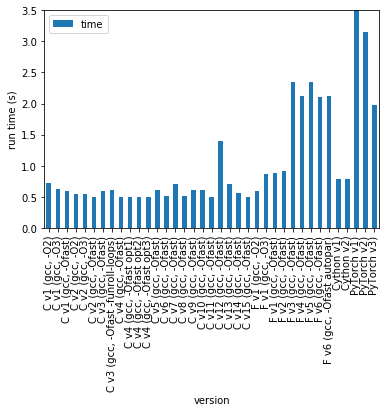

In [4]:
t.plot.bar(x='version', y='time', ylim=(0, 3.5))
plt.ylabel('run time (s)')

Note that I clipped the y-axis at 3.5 s - the slowest PyTorch version actually took 14 s! Unsurprisingly, with only two cores, using OpenMP provides a smaller performance boost than it did with eight cores. There are a few other differences compared to the previous measurements, but I am most interested in the new implementations (on the right of the graph). Cython performance is not terrible, but it doesn't match the pure C versions. PyTorch makes development easy, but, as I found in my [GPU measurements](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/notebooks/wave_2d_fd_perf_gpu.ipynb), its poor performance makes it worthwhile to invest effort in a different implementation.

### Memory alignment

In addition to altering the way the computation is structured, such as by using cache blocking, another way of helping to reduce unnecessary memory accesses is by ensuring that the arrays are properly aligned in memory. Memory is accessed in chunks that start at specific multiples of the chunk size. For a vectorized computation, you therefore ideally want to ensure that the start of each vector is aligned with the start of one of these chunks to avoid loading values from memory and then only using some of them. For example, with misaligned data access, you could get unlucky and have one vector of computation start one cell from the end of a memory chunk. That whole chunk will be read from memory, even though you are only going to use one cell from it. In reality, memory alignment is usually not very important for CPUs, since they have features to reduce the impact of misaligned memory access. It is crucial when running on accelerators such as GPUs, however.

For my first test, I will run all of the implementations with the memory allocated and padded to ensure that the first cell in each row has a 256-bit alignment, and then compare the results with those I got above without any alignment.

In [16]:
t_align256 = run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=[2000], align=256)

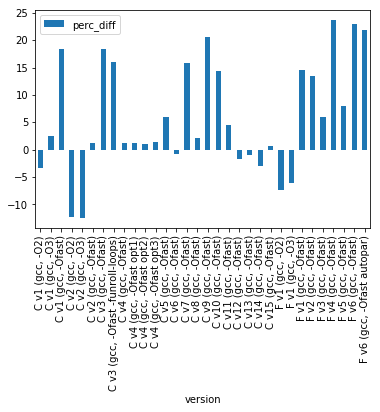

In [38]:
t_diff = t_align256.copy()
t_diff = t_diff[t_diff['version'] != 'C v6 256 (gcc, -Ofast)'].reset_index(True)
t_diff['diff'] = t_diff['time'] - t['time']
t_diff['perc_diff'] = t_diff['diff'] / t['time'] * 100
t_diff.plot.bar(y='perc_diff', x='version', rot=90)

The above plot shows the percentage change in run time when the memory is aligned, compared to when it isn't. Positive number mean that the aligned version was slower. Somewhat surprisingly, it seems that in many cases the aligned one was indeed slower, sometimes by quite a bit. I can only think of two possible explanations for this at the moment.

One is that timing code on a cloud instance is not very reliable. The numbers were obtained by repeating each measurement 30 times to try to counter this, but it is possible that some of the variability could be explained in this way. 

The second is that aligning the beginning of each row requires padding the end of each row. This means that at the end of each row, the computation needs to make a bigger jump in memory to get to the next row when the data is aligned than when it isn't. These big jumps could be interfering with the smooth streaming of data. For example, data is less likely to be prefetched when accesses exhibit less spatial locality. Big jumps may also cause a [TLB](https://en.wikipedia.org/wiki/Translation_lookaside_buffer) miss, delaying the computation.

To investigate a bit further, I below run VC6 for a range of alignment values.

In [9]:
versions=[{'class': VC6_Ofast_gcc, 'name': 'C v6 (gcc, -Ofast)'}]
t_align = pd.DataFrame()
tmp = run_timing.run_timing_model_size(num_repeat=1, num_steps=10, model_sizes=np.linspace(2000, 2500, 100, dtype=np.int), versions=versions)
tmp['align'] = 0
t_align = t_align.append(tmp, ignore_index=True)
for align in [8, 16, 32, 64, 128, 256, 512, 1024]:
    tmp = run_timing.run_timing_model_size(num_repeat=1, num_steps=10, model_sizes=np.linspace(2000, 2500, 100, dtype=np.int), versions=versions, align=align)
    tmp['align'] = align
    t_align = t_align.append(tmp, ignore_index=True)

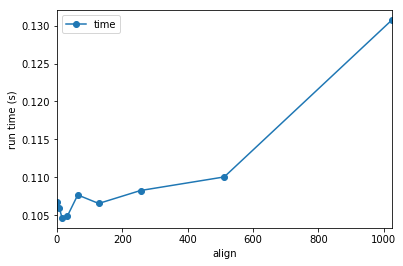

In [17]:
t_align.groupby('align').mean().plot(y='time', style='o-')
plt.ylabel('run time (s)');

This plot suggests that an alignment of 16 bits provides a slight performance improvement, but after that the performance decreases as the number of bits that the alignment is required to be a multiple of increases. Ensuring that the data is aligned in this way is therefore certainly not a guarantee of improved performance on a CPU.

As a final test related to alignment, I compare VC6 and VC6 256. The latter contains functions to inform the GCC compiler that the memory is aligned on 256-bit boundaries (as it does not know this otherwise at compile time). The run time is approximately the same, so this doesn't seem to be beneficial in this case.

In [18]:
print('C v6 (gcc, -Ofast)', t_align256.loc[t_align256['version'] == 'C v6 (gcc, -Ofast)', 'time'])
print('C v6 256 (gcc, -Ofast)', t_align256.loc[t_align256['version'] == 'C v6 256 (gcc, -Ofast)', 'time'])

C v6 (gcc, -Ofast) 13    0.082497
Name: time, dtype: float64
C v6 256 (gcc, -Ofast) 14    0.082274
Name: time, dtype: float64


### Varying model size

We previously looked at the performance of various implementations for a 2000 x 2000 cell model. VC6 seemed to be the best performer there, but let's see how it and a few other implementations do when the model size changes from 1000 x 1000 cells to 5000 x 5000 cells.

In [37]:
versions=[{'class': VC1_Ofast_gcc, 'name': 'C v1 (gcc, -Ofast)'},
          {'class': VC2_Ofast_gcc, 'name': 'C v2 (gcc, -Ofast)'},
          {'class': VC6_Ofast_gcc, 'name': 'C v6 (gcc, -Ofast)'},
          {'class': VC8_Ofast_gcc, 'name': 'C v8 (gcc, -Ofast)'}]
t_modelsize=run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=np.linspace(1000, 5000, 5, dtype=np.int), versions=versions, align=256)

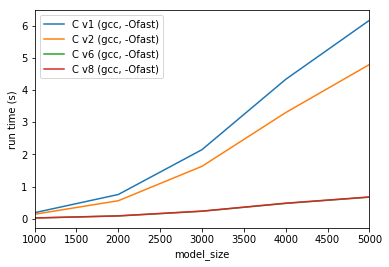

In [40]:
ax=plt.subplot(111)
for v in versions:
    t_modelsize.loc[t_modelsize['version'] == v['name']].plot(x='model_size', y='time', label=v['name'], ax=ax)
plt.ylabel('run time (s)');

The advantage of manually unrolling the loop over finite difference coefficients, the only difference between VC1 and VC2, is significant at all model sizes. For the largest model, the difference in run time is more than 1 s. The significant advantage of multithreading also continues over all model sizes, with VC6 and VC8 being about five times faster than VC2 on the largest model. Cache blocking does not affect the run time at any of these model sizes, with VC8 overlapping VC6.

### Number of cells per second

We can also look at the previous result for VC6 in another way. Rather than time to process the whole model, below I plot the number of seconds needed to process each cell as the model sizes changes. The result surprised me, as I thought it would linearly increase with model size due to the fixed overheads of starting the computation being divided over a larger number of cells, but in fact it is close to the opposite. My main theory for explaining this is similar to what we saw earlier: with small models the whole row can be stored in cache. Quite interestingly, the plot changes direction after the 4000 x 4000 model size, and 4000 x 16 x 4 = 250 KB, which is about the size of the L2 cache. Although this seems to make sense, if it is true one would have expected VC8 to perform differently, due to its cache blocking, but we saw above that it has the same performance as VC6 for all model sizes. Further investigation, employing the likes of the Linux `perf` command to record cache misses, may be required.

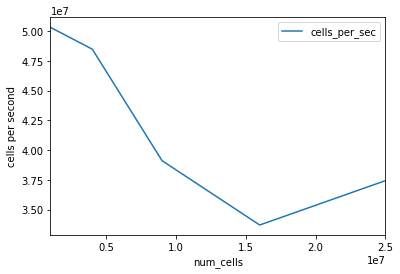

In [57]:
t_cellpersec = t_modelsize[t_modelsize['version'] == 'C v6 (gcc, -Ofast)'].copy()
t_cellpersec['num_cells'] = t_cellpersec['model_size']**2
t_cellpersec['cells_per_sec'] = t_cellpersec['num_cells'] / t_cellpersec['time']
t_cellpersec.plot(x='num_cells', y='cells_per_sec')
plt.ylabel('cells per second');

### Number of time steps

As a final test, I will try varying the number of time steps that the propagator runs for before it returns the result to my Python code. The experiments above all used 10 time steps, so this time I will try between 1 and 100 time steps.

In the comparison of 1D propagators, the version that opened an OpenMP parallel section around the time step loop, rather than creating a new OpenMP parallel section inside each time step, had a performance advantage. This seemed reasonable, since spawning threads takes some time so we would like to avoid doing it every time step. The same idea is implemented in VC11 of my 2D propagators, so here I compare that with VC6.

In [44]:
versions=[{'class': VC6_Ofast_gcc, 'name': 'C v6 (gcc, -Ofast)'},
          {'class': VC11_Ofast_gcc, 'name': 'C v11 (gcc, -Ofast)'}]
t_numsteps=run_timing.run_timing_num_steps(num_repeat=100, num_steps=np.linspace(1, 100, 5, dtype=np.int), model_size=2000, versions=versions, align=256)

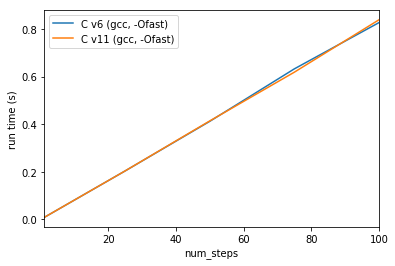

In [45]:
ax=plt.subplot(111)
for v in versions:
    t_numsteps.loc[t_numsteps['version'] == v['name']].plot(x='num_steps', y='time', label=v['name'], ax=ax)
plt.ylabel('run time (s)')

The first thing to notice is that there is no performance difference between VC6 and VC11. I do not find this hugely surprising, as there is significantly more computation per time step in the 2D case than the 1D case, and so in 2D, unlike in 1D, the overhead of spawning threads each time step is negligible compared to the computation.

The second feature of note here is that the y-intercept is very close to 0 s. This is good news, as it shows that the overhead of calling the propagator from Python is very small, so we do not pay a large performance penalty for this. We can therefore enjoy the convenience of using Python in the less performance-critical parts of our code guilt-free.


## Conclusions

I was surprised by quite a few of the experiments.

* Cache blocking does not seem to be necessary for 2D propagators on some systems (except, potentially, for very large models).
* Manually unrolling loops is the only way to guarantee maximum performance - you can't rely on `-funroll-loops`.
* Fortran's `forall` and `do concurrent` seem to perform worse than just using plain `do` loops, at least with Gfortran.
* Putting computations into `pure` functions in Fortran can significantly reduce performance.
* Ensuring that the start of each row has a certain byte alignment can make performance non-negligibly worse, with little potential benefit on CPUs.
* Overhead of calling from Python was low

The main take-away is that it seems best to keep the code as simple as possible. Cache blocking and memory alignment not only make the code more complicated, but may even make the performance worse.